<a href="https://colab.research.google.com/github/Rebel095/data_analysis/blob/main/Customer_Segmentation_with_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача сегментировать клиентов с помощью RFM-анализа

**Нужно взять выгрузку из базы данных и рассчитать для каждого клиента:**

* Recency — давность (количество дней с последней покупки);
* Frequency — частота (сумма всех покупок);
* Monetary — денежная ценность (сумма дохода от всех покупок).

In [ ]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import numpy as np
!apt-get install python3.5

In [ ]:
from google.colab import files

Выгружаем из CRM или из системы веб-аналитики данные по транзакциям:

* клиент (User ID);
* дата покупки;
* сумма покупки.

In [ ]:
files.upload()

Saving RFM.csv to RFM.csv
Saving RFM_2.csv to RFM_2.csv


# Удержание клиентов и привычки тратить
Прежде чем углубляться в сегментацию, сначала проанализируем уровень удержания и привычки наших пользователей к расходам. Для этого мы проанализируем наших клиентов за год и посмотрим, сколько из них перестали покупать и сколько потратили.

## Retention Rate

In [ ]:
df1 = pd.read_csv('RFM.csv')
df2 = pd.read_csv('RFM_2.csv')
df = df1.append(df2)
df.columns = map(str.lower, df.columns)
df

<ipython-input-4-f6c213c31d92>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


,client_id,purchase_date,purchase_sum
0,99087105,2020-07-22,200
1,12897695,2020-07-22,1250
2,10998598,2020-07-22,2990
3,5724600,2020-07-22,1400
4,14222661,2020-07-22,1592
...,...,...,...
999994,74239613,2020-07-22,708
999995,99121329,2020-07-22,50
999996,68258509,2020-07-22,300
999997,92656809,2020-07-22,100


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048574 entries, 0 to 999998
Data columns (total 3 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   client_id      int64 
 1   purchase_date  object
 2   purchase_sum   int64 
dtypes: int64(2), object(1)
memory usage: 62.5+ MB


In [ ]:
# Считаем количество покупок у каждого клиента
purchase_counts = df['client_id'].value_counts()

# Определяем клиентов, совершивших более одной покупки
repeat_customers = purchase_counts[purchase_counts > 1].count()

# Подсчитываем общее количество уникальных клиентов
total_unique_customers = df['client_id'].nunique()

# Расчитываем долю постоянных клиентов
repeat_customer_ratio = repeat_customers / total_unique_customers
repeat_customer_ratio

0.41957278125469183

Доля постоянных клиентов 41%. В целом, это не мало. Сегментация по RFM-анализу подойдет тем бизнесам, которые ориентированы на регулярные покупки: интернет-магазину косметики или кормов для животных, маркетплейсам, B2B-компаниям. А вот для бизнеса с редкими покупками RFM-сегментация будет бесполезна: это, например, автобизнес и продажа недвижимости.



In [ ]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

In [ ]:
first_activity_date = df.groupby(['client_id'])['purchase_date'].min()
first_activity_date.name = 'first_activity_date'
df_3 = df.join(first_activity_date,on='client_id')
df_3

,client_id,purchase_date,purchase_sum,first_activity_date
0,99087105,2020-07-22,200,2020-07-18
1,12897695,2020-07-22,1250,2020-07-22
2,10998598,2020-07-22,2990,2020-07-22
3,5724600,2020-07-22,1400,2020-07-16
4,14222661,2020-07-22,1592,2020-07-02
...,...,...,...,...
999994,74239613,2020-07-22,708,2020-07-22
999995,99121329,2020-07-22,50,2020-07-22
999996,68258509,2020-07-22,300,2020-07-20
999997,92656809,2020-07-22,100,2020-07-22


In [ ]:
purchase_grouped_by_cohorts = df_3.groupby(
    ['first_activity_date', 'purchase_date']
).agg({'purchase_sum': 'sum', 'client_id': 'nunique'})
print(purchase_grouped_by_cohorts.head())

                                   purchase_sum  client_id
first_activity_date purchase_date                         
2020-07-01          2020-07-01          4810753       4215
                    2020-07-02            98053         81
                    2020-07-03            64737         79
                    2020-07-04            46155         75
                    2020-07-05            55130         78


In [ ]:
purchase_grouped_by_cohorts = purchase_grouped_by_cohorts.reset_index()
purchase_grouped_by_cohorts['cohort_lifetime'] = (
    purchase_grouped_by_cohorts['purchase_date']
    - purchase_grouped_by_cohorts['first_activity_date']
)
purchase_grouped_by_cohorts['cohort_lifetime'].head()

0   0 days
1   1 days
2   2 days
3   3 days
4   4 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [ ]:
purchase_grouped_by_cohorts['cohort_lifetime'] = purchase_grouped_by_cohorts[
    'cohort_lifetime'
] / np.timedelta64(1, 'M')
print(purchase_grouped_by_cohorts['cohort_lifetime'].head())

0    0.000000
1    0.032855
2    0.065710
3    0.098565
4    0.131420
Name: cohort_lifetime, dtype: float64


In [ ]:
purchase_grouped_by_cohorts['cohort_lifetime'] = (
    purchase_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
)
purchase_grouped_by_cohorts

,first_activity_date,purchase_date,purchase_sum,client_id,cohort_lifetime
0,2020-07-01,2020-07-01,4810753,4215,0
1,2020-07-01,2020-07-02,98053,81,0
2,2020-07-01,2020-07-03,64737,79,0
3,2020-07-01,2020-07-04,46155,75,0
4,2020-07-01,2020-07-05,55130,78,0
...,...,...,...,...,...
59904,2021-07-14,2021-07-15,69434,57,0
59905,2021-07-14,2021-07-16,27196,21,0
59906,2021-07-15,2021-07-15,3115299,1856,0
59907,2021-07-15,2021-07-16,32212,39,0


In [ ]:
purchase_grouped_by_cohorts['first_order_month'] = purchase_grouped_by_cohorts[
    'first_activity_date'
].dt.strftime('%Y-%m')
purchase_grouped_by_cohorts

,first_activity_date,purchase_date,purchase_sum,client_id,cohort_lifetime,first_order_month
0,2020-07-01,2020-07-01,4810753,4215,0,2020-07
1,2020-07-01,2020-07-02,98053,81,0,2020-07
2,2020-07-01,2020-07-03,64737,79,0,2020-07
3,2020-07-01,2020-07-04,46155,75,0,2020-07
4,2020-07-01,2020-07-05,55130,78,0,2020-07
...,...,...,...,...,...,...
59904,2021-07-14,2021-07-15,69434,57,0,2021-07
59905,2021-07-14,2021-07-16,27196,21,0,2021-07
59906,2021-07-15,2021-07-15,3115299,1856,0,2021-07
59907,2021-07-15,2021-07-16,32212,39,0,2021-07


In [ ]:
cohorts = purchase_grouped_by_cohorts.groupby(['first_order_month','cohort_lifetime']).agg({'client_id':'nunique'}).reset_index()
cohorts

,first_order_month,cohort_lifetime,client_id
0,2020-07,0,113
1,2020-07,1,69
2,2020-07,2,56
3,2020-07,3,53
4,2020-07,4,51
...,...,...,...
87,2021-05,1,21
88,2021-05,2,14
89,2021-06,0,84
90,2021-06,1,17


In [ ]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_order_month', 'client_id']
]
initial_users_count

,first_order_month,client_id
0,2020-07,113
13,2020-08,108
25,2020-09,93
36,2020-10,84
46,2020-11,73
55,2020-12,87
63,2021-01,79
70,2021-02,86
76,2021-03,91
82,2021-04,85


In [ ]:
initial_users_count = initial_users_count.rename(columns={'client_id':'cohort_users'})

In [ ]:
cohorts = cohorts.merge(initial_users_count,on='first_order_month')

cohorts

,first_order_month,cohort_lifetime,client_id,cohort_users
0,2020-07,0,113,113
1,2020-07,1,69,113
2,2020-07,2,56,113
3,2020-07,3,53,113
4,2020-07,4,51,113
...,...,...,...,...
87,2021-05,1,21,74
88,2021-05,2,14,74
89,2021-06,0,84,84
90,2021-06,1,17,84


In [ ]:
cohorts['retention'] = cohorts['client_id']/cohorts['cohort_users']

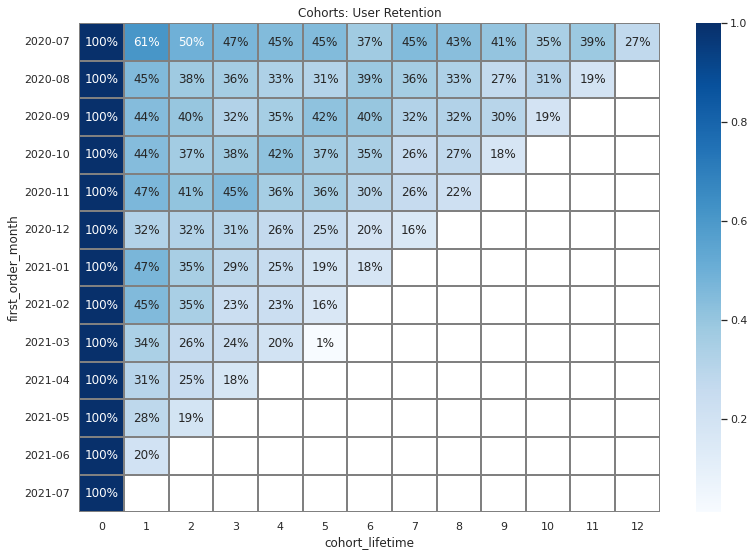

In [ ]:
retention_pivot = cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='gray', cmap = "Blues");

Retention Rate в первый месяц убывает по когортам с течением времени. Если для когорты пользователей, первый раз купивших в июле 2020 Retention Rate в первый месяц составлял 61%, то для пользователей, первый раз купивших в мае 2021 — уже 28%. Так, за 10 месяцев коэффициент удержания упал на 33%. Это говорит, что с каждой новой когортой поведение покупателей меняется. Всё меньше повторных покупок. Возможно, были выбраны неэффективные источники трафика или ухудшилось качество предложений на сайте.

Если смотреть на картину в целом, то уровень удержания  не очень высок. Особенно у когорты 2020-12. Возможно, в декабре были разовые покупки под новогодние праздники в качестве подарка.


# Покупательские привычки

## Среднее количество покупок на одного пользователя

In [ ]:
df

,client_id,purchase_date,purchase_sum
0,99087105,2020-07-22,200
1,12897695,2020-07-22,1250
2,10998598,2020-07-22,2990
3,5724600,2020-07-22,1400
4,14222661,2020-07-22,1592
...,...,...,...
999994,74239613,2020-07-22,708
999995,99121329,2020-07-22,50
999996,68258509,2020-07-22,300
999997,92656809,2020-07-22,100


In [ ]:
report = df.copy()
report['order_month'] = report['purchase_date'].astype('datetime64[M]').dt.strftime('%Y-%m')
report = report.groupby('order_month').agg({'client_id': 'nunique', 'purchase_date':'count', 'purchase_sum': 'sum'})
report.columns = ['users', 'orders', 'total_revenue']
report['orders_per_user'] = (report['orders'] / report['users']).round(2)
report


,users,orders,total_revenue,orders_per_user
order_month,,,,
2020-07,116610,158169,176265853,1.36
2020-08,119745,160128,176272240,1.34
2020-09,123910,161772,181970474,1.31
2020-10,109160,140921,154349490,1.29
2020-11,99530,127392,134935086,1.28
2020-12,121054,161039,170843054,1.33
2021-01,104769,135105,152398508,1.29
2021-02,148810,195809,223509598,1.32
2021-03,157111,207920,228428239,1.32


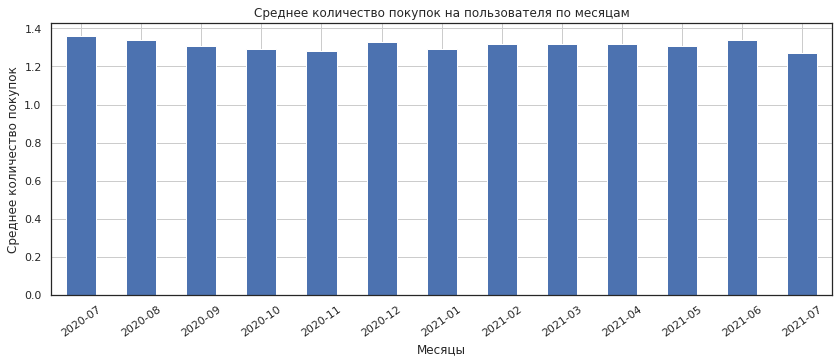

In [ ]:
ax = (
    report
    .pivot_table(index='order_month', values='orders_per_user')
    .plot(y='orders_per_user', kind='bar', figsize=(14, 5), title='Среднее количество покупок на пользователя по месяцам', grid=True, legend=False)
)
plt.ylabel('Среднее количество покупок')
plt.xlabel('Месяцы')
plt.xticks(rotation = 35)

plt.show()


Среднее количество покупок на одного пользователя с течением времени не меняется остается на уровне 1,3

## Средний чек

In [ ]:
report['revenue_per_user'] = (report['total_revenue'] / report['orders']).round(2)
report

,users,orders,total_revenue,orders_per_user,revenue_per_user
order_month,,,,,
2020-07,116610,158169,176265853,1.36,1114.41
2020-08,119745,160128,176272240,1.34,1100.82
2020-09,123910,161772,181970474,1.31,1124.86
2020-10,109160,140921,154349490,1.29,1095.29
2020-11,99530,127392,134935086,1.28,1059.21
2020-12,121054,161039,170843054,1.33,1060.88
2021-01,104769,135105,152398508,1.29,1128.00
2021-02,148810,195809,223509598,1.32,1141.47
2021-03,157111,207920,228428239,1.32,1098.64


In [ ]:
report['revenue_per_user'].describe()

count      13.000000
mean     1099.217692
std        51.893045
min      1006.330000
25%      1062.740000
50%      1098.640000
75%      1124.860000
max      1222.380000
Name: revenue_per_user, dtype: float64

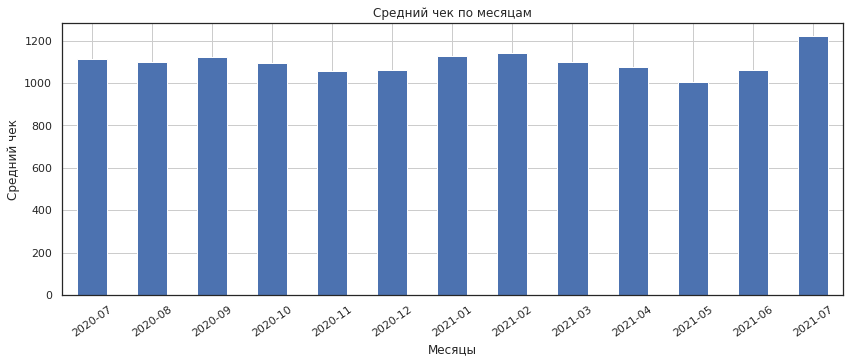

In [ ]:
ax = (
    report
    .pivot_table(index='order_month', values='revenue_per_user')
    .plot(y='revenue_per_user', kind='bar', figsize=(14, 5), title='Средний чек по месяцам', grid=True, legend=False)
)
plt.ylabel('Средний чек')
plt.xlabel('Месяцы')
plt.xticks(rotation = 35)

plt.show()

Средни чек от месяца к месяцу меняется несущественно. Самый низкий средний чек был в мае 2021, а самый высокий в июле 2021.

## LTV

In [ ]:
report_ltv = df_3.copy()
report_ltv

,client_id,purchase_date,purchase_sum,first_activity_date
0,99087105,2020-07-22,200,2020-07-18
1,12897695,2020-07-22,1250,2020-07-22
2,10998598,2020-07-22,2990,2020-07-22
3,5724600,2020-07-22,1400,2020-07-16
4,14222661,2020-07-22,1592,2020-07-02
...,...,...,...,...
999994,74239613,2020-07-22,708,2020-07-22
999995,99121329,2020-07-22,50,2020-07-22
999996,68258509,2020-07-22,300,2020-07-20
999997,92656809,2020-07-22,100,2020-07-22


In [ ]:
report_ltv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048574 entries, 0 to 999998
Data columns (total 4 columns):
 #   Column               Dtype         
---  ------               -----         
 0   client_id            int64         
 1   purchase_date        datetime64[ns]
 2   purchase_sum         int64         
 3   first_activity_date  datetime64[ns]
dtypes: datetime64[ns](2), int64(2)
memory usage: 78.1 MB


In [ ]:
#Посчитаем количество новых покупателей (n_buyers) за каждый месяц:
report_ltv['purchase_date'] = report_ltv['purchase_date'].astype('datetime64[M]')
report_ltv['first_purchase_date'] = report_ltv['first_activity_date'].astype('datetime64[M]')
cohort_sizes = (
    report_ltv.groupby('first_purchase_date')
    .agg({'client_id': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']
print(cohort_sizes.head())

  first_purchase_date  n_buyers
0          2020-07-01    116610
1          2020-08-01    100108
2          2020-09-01     94205
3          2020-10-01     75546
4          2020-11-01     63053


In [ ]:
cohorts_ltv = (
    report_ltv.groupby(['first_purchase_date', 'purchase_date'])
    .agg({'purchase_sum': 'sum'})
    .reset_index()
)
print(cohorts_ltv.head())

  first_purchase_date purchase_date  purchase_sum
0          2020-07-01    2020-07-01     176265853
1          2020-07-01    2020-08-01      25880916
2          2020-07-01    2020-09-01      20171347
3          2020-07-01    2020-10-01      16667188
4          2020-07-01    2020-11-01      13938604


In [ ]:
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц
report_2 = pd.merge(cohort_sizes, cohorts_ltv, on='first_purchase_date')
print(report_2.head())

  first_purchase_date  n_buyers purchase_date  purchase_sum
0          2020-07-01    116610    2020-07-01     176265853
1          2020-07-01    116610    2020-08-01      25880916
2          2020-07-01    116610    2020-09-01      20171347
3          2020-07-01    116610    2020-10-01      16667188
4          2020-07-01    116610    2020-11-01      13938604


In [ ]:
# добавим возраст когорты
report_2['age'] = (
    report_2['purchase_date'] - report_2['first_purchase_date']
) / np.timedelta64(1, 'M')
report_2['age'] = report_2['age'].round().astype('int')
print(report_2.head())

  first_purchase_date  n_buyers purchase_date  purchase_sum  age
0          2020-07-01    116610    2020-07-01     176265853    0
1          2020-07-01    116610    2020-08-01      25880916    1
2          2020-07-01    116610    2020-09-01      20171347    2
3          2020-07-01    116610    2020-10-01      16667188    3
4          2020-07-01    116610    2020-11-01      13938604    4


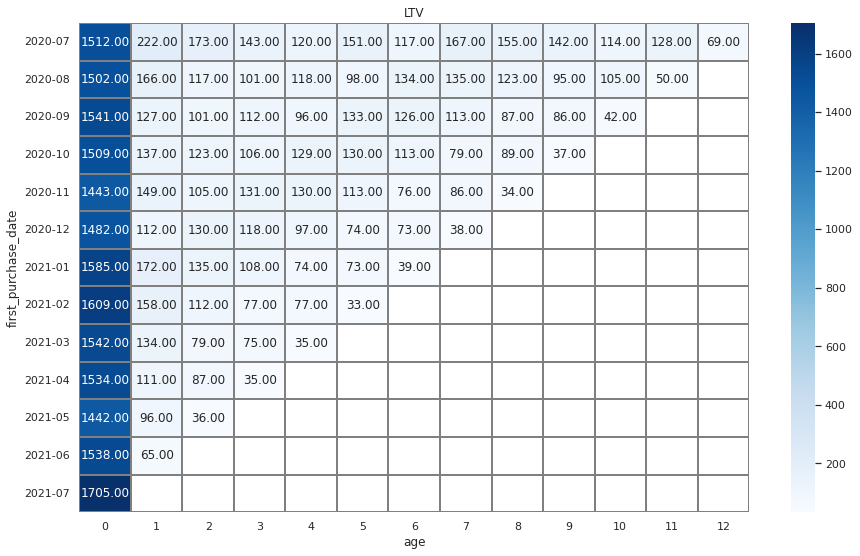

In [ ]:
report_2['first_purchase_date'] = report_2['first_purchase_date'].dt.strftime('%Y-%m')
report_2['ltv'] = report_2['purchase_sum'] / report_2['n_buyers']

output = report_2.pivot_table(
    index='first_purchase_date', columns='age', values='ltv', aggfunc='mean'
).round()




sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', cmap = "Blues");

In [ ]:
def ltv_table(output):
  n = output.index.get_level_values(0)
  for i in n:
    ltv_sum = output.loc[i].sum()
    print('{} | {:.2F} '.format(i, ltv_sum))
print('LTV')
print('----------------------------')
ltv_table(output)

LTV
----------------------------
2020-07 | 3213.00 
2020-08 | 2744.00 
2020-09 | 2564.00 
2020-10 | 2452.00 
2020-11 | 2267.00 
2020-12 | 2124.00 
2021-01 | 2186.00 
2021-02 | 2066.00 
2021-03 | 1865.00 
2021-04 | 1767.00 
2021-05 | 1574.00 
2021-06 | 1603.00 
2021-07 | 1705.00 


В среднем каждый покупатель из первой когорты принес по 3213 рублей прибыли за 13 месяцев «жизни». В целом, наблюдается тенденция по снижению LTV из в последующих когортах.

# Recency, Frequency, and Monetary (RFM) Сегментация

1. **Давность** — сколько времени прошло с момента последнего действия или покупки.

2. **Частота** — как часто пользователь взаимодействовал с брендом в течение определенного периода времени.

3. **Денежная ценность** — сколько покупатель потратил денег в течение определенного периода времени. Деление денежной ценности на частоту показывает среднюю сумму покупки — важный второстепенный фактор, который следует учитывать при сегментировании клиентов.

In [ ]:
# Рассчитываем давность, частоту и денежную ценность для каждого платящего клиента

paying_clients = df.copy()
current_date = paying_clients['purchase_date'].max()
rfm = paying_clients.groupby(['client_id']).agg({
    'purchase_date': lambda x: (current_date - x.max()).days,
    'client_id': 'count',
    'purchase_sum': 'sum'})
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
client_id,,,
999135,74,1,225
999141,365,1,200
999150,64,10,2820
999190,52,1,1152
999235,177,2,3390
...,...,...,...
102378187,0,1,2244
102378259,0,1,225
102378263,0,1,225


In [ ]:
current_date

Timestamp('2021-07-16 00:00:00')

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992419 entries, 999135 to 102378359
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Recency        992419 non-null  int64
 1   Frequency      992419 non-null  int64
 2   MonetaryValue  992419 non-null  int64
dtypes: int64(3)
memory usage: 30.3 MB


Рассчитываем медиану по давности и доходу, а также средний доход.

In [ ]:
print("Медиана по давности:", rfm['Recency'].median())
print("Медиана по доходу:", rfm['MonetaryValue'].median())
print("Средний доход:", rfm['MonetaryValue'].mean())

Медиана по давности: 139.0
Медиана по доходу: 1015.0
Средний доход: 2259.1281192722026


Будем отталкиваться от этих показателей.
Горячими клиентами будем считать тех, кто купил за последние 30 дней.

**Простановка баллов Recency:**

* если Recency ≤ 30, тогда присваиваем 3 балла;

* если Recency > 30 и Recency ≤ 139, тогда присваиваем 2 балла;

* если Recency > 139, тогда 1 балл.

In [ ]:
def recency_score(x):
  if x['Recency'] <= 30:
    recency = 3
  elif x['Recency'] > 30 and x['Recency'] <= 139:
    recency = 2
  else:
    recency = 1

  return recency

rfm["R"] = rfm.apply(recency_score, axis=1)

**Простановка баллов Frequency:**

* если Frequency = 1, тогда 1 балл;
* если Frequency = 2, тогда 2 балла;
* если Frequency > 2, тогда 3 балла.

In [ ]:
def frequency_score(x):
  if x['Frequency'] == 1:
    frequency = 1
  elif x['Frequency'] == 2:
    frequency = 2
  else:
    frequency = 3

  return frequency

rfm["F"] = rfm.apply(frequency_score, axis=1)

**Простановка баллов Monetary:**

* если Monetary < 1015, тогда 1 балл;

* если Monetary ≥ 1015 и Monetary < 2259, тогда 2 балла;

* если Monetary > 2259, тогда 3 балла.

In [ ]:
def monetary_score(x):
  if x['MonetaryValue'] < 1015:
    monetary = 1
  elif x['MonetaryValue'] > 1015 and x['MonetaryValue'] < 2259:
    monetary = 2
  else:
    monetary = 3

  return monetary

rfm["M"] = rfm.apply(monetary_score, axis=1)

In [ ]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M
client_id,,,,,,
999135,74,1,225,2,1,1
999141,365,1,200,1,1,1
999150,64,10,2820,2,3,3
999190,52,1,1152,2,1,2
999235,177,2,3390,1,2,3
...,...,...,...,...,...,...
102378187,0,1,2244,3,1,2
102378259,0,1,225,3,1,1
102378263,0,1,225,3,1,1


Это называется сегментированной таблицей RFM.

Чтобы получить окончательную оценку RFM, объединим числа. Таким образом, клиент с самым высоким рейтингом будет иметь оценку RFM 333, а c самым низким — 111.

In [ ]:
def rfm_score(row):
  return str(row['R']) + str(row['F']) + str(row['M'])
rfm['RFM_Score'] = rfm.apply(rfm_score, axis=1)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score
client_id,,,,,,,
999135,74,1,225,2,1,1,211
999141,365,1,200,1,1,1,111
999150,64,10,2820,2,3,3,233
999190,52,1,1152,2,1,2,212
999235,177,2,3390,1,2,3,123
...,...,...,...,...,...,...,...
102378187,0,1,2244,3,1,2,312
102378259,0,1,225,3,1,1,311
102378263,0,1,225,3,1,1,311


**Расшифровка сегментов:**

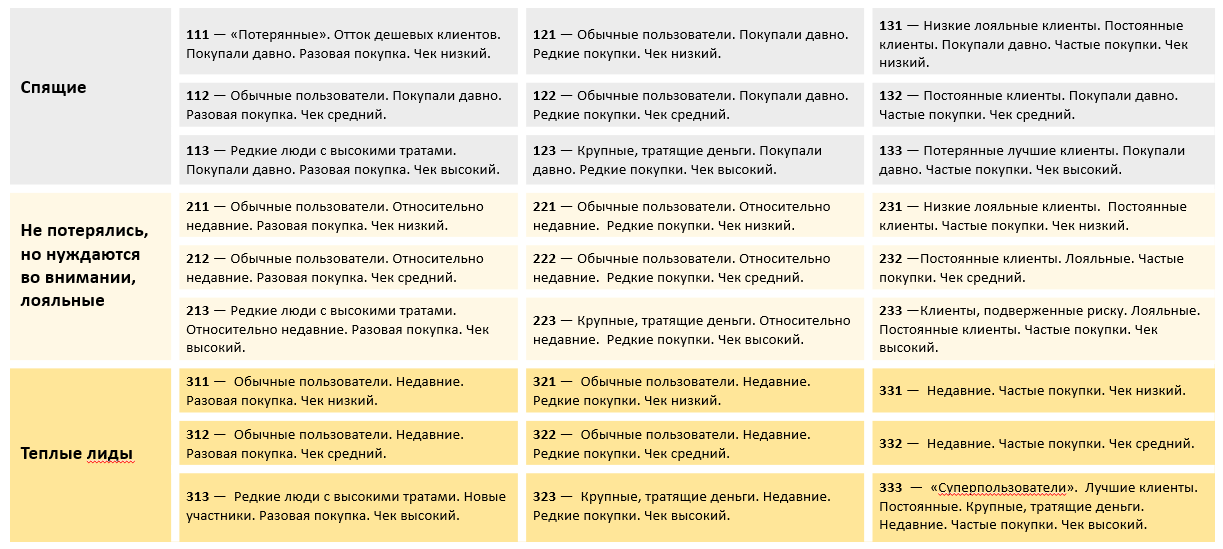

Сохраняем себе фаил

In [ ]:
from google.colab import files
rfm.to_csv('rfm-result.csv')
files.download('rfm-result.csv')

**Визуализировать данные можно, например, вот так:**

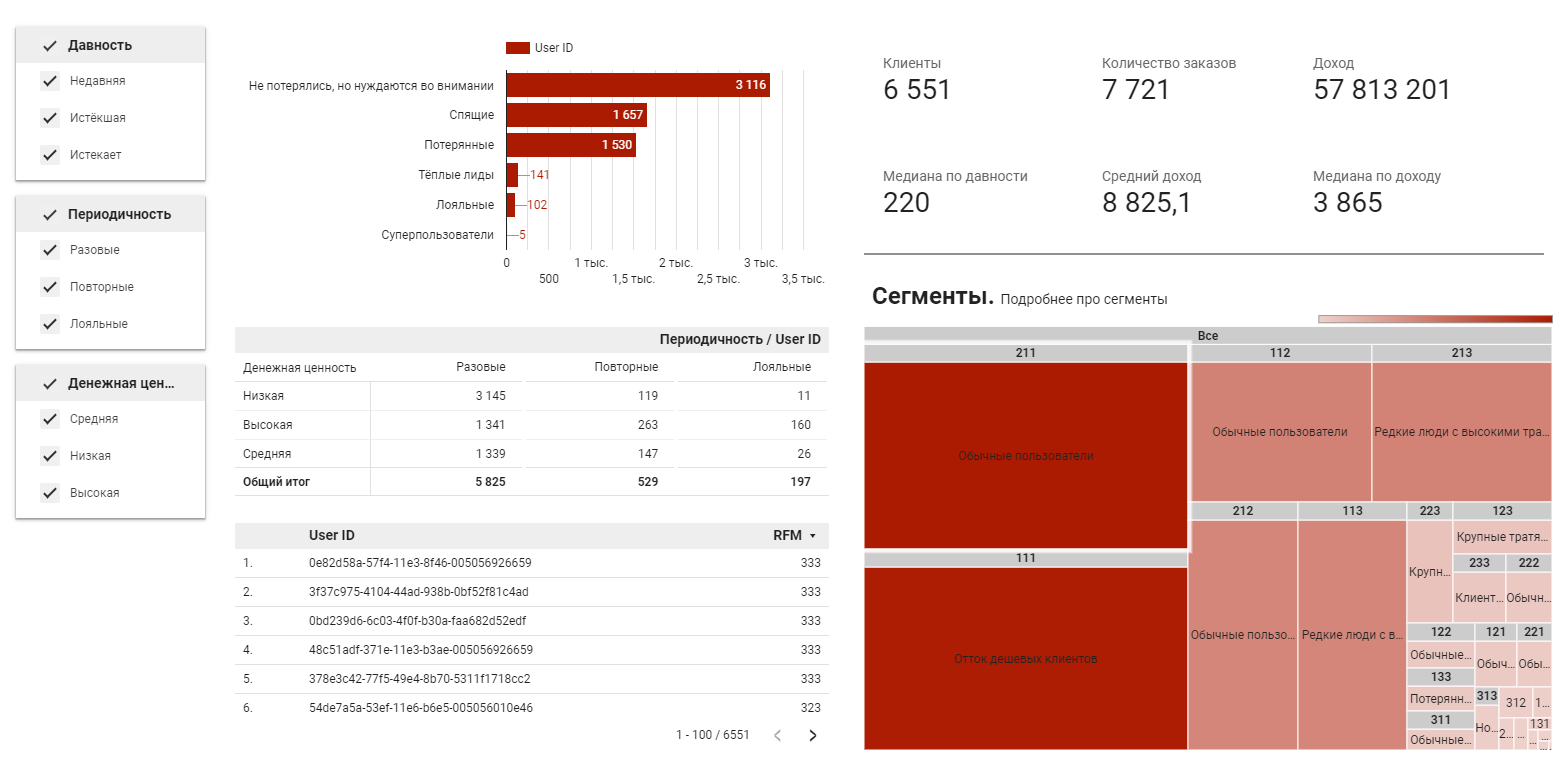
*Визуализация показана для примера, она не построена на данных данного анализа*